In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from lightgbm import LGBMClassifier

## Create Fake users

In [3]:
# Fix the random seed so results are reproducible
random.seed(42)

# Number of synthetic users you want to create
num_users = 100000

# Generate user IDs (1 to num_users)
user_ids = range(1, num_users + 1)

# Generate random ages between 18 and 70
ages = [random.randint(18, 70) for _ in range(num_users)]

# Random genders (feel free to expand beyond binary)
genders = [random.choice(['male', 'female']) for _ in range(num_users)]

# Define a pool of possible hobbies
possible_hobbies = [
    'cars', 'tech', 'music', 'fashion', 'books',
    'art', 'sports', 'gaming', 'cooking', 'travel'
]

In [4]:
# Helper function to pick a random subset of hobbies
def pick_hobbies():
    # Randomly choose how many hobbies this user will have (1 to 3)
    num_hobbies = random.randint(1, 3)
    chosen = random.sample(possible_hobbies, num_hobbies)
    # Return them as a comma-separated string (e.g., "cars,gaming")
    return ",".join(chosen)

# Create the hobbies column
hobbies_list = [pick_hobbies() for _ in range(num_users)]

# Assemble into a DataFrame
users_df = pd.DataFrame({
    'user_id': user_ids,
    'age': ages,
    'gender': genders,
    'hobbies': hobbies_list
})

In [5]:
# Show a sample
print(users_df.head(10))

   user_id  age  gender                hobbies
0        1   58    male                 sports
1        2   25    male                 travel
2        3   19  female         gaming,fashion
3        4   65  female     fashion,gaming,art
4        5   35  female   cooking,tech,fashion
5        6   33    male          books,cooking
6        7   32    male           books,gaming
7        8   26    male           tech,fashion
8        9   65  female           tech,fashion
9       10   24    male  travel,fashion,gaming


In [6]:
# Save to CSV
users_df.to_csv("users.csv", index=False)
print("Synthetic users.csv created with", num_users, "users!")

Synthetic users.csv created with 100000 users!


## Simulation of User-Product Interactions Table

In [7]:
# 1) Load users and products
categories_df = pd.read_csv("amazon_categories.csv")  # category_id, category_name
users_df = pd.read_csv("users.csv")  # user_id, age, gender, hobbies, ...
products_df = pd.read_csv("amazon_products_cleaned.csv")  # asin (or product_id), price, category_id, ...

# 2) Merge categories onto products via category_id
#    Note: 'category_id' in products_df matches 'id' in categories_df
merged_products_df = pd.merge(
    products_df, 
    categories_df,
    left_on="category_id", 
    right_on="id",  # from categories.csv
    how="left"
)

# Rename for clarity: we'll keep 'category_name' but drop 'id' if redundant
merged_products_df.drop(columns=["id"], inplace=True)

# Let's rename 'asin' to 'product_id' to keep naming consistent
merged_products_df.rename(columns={'asin': 'product_id'}, inplace=True)

# Now merged_products_df has:
# product_id, title, price, category_id, isBestSeller, category_name, ...
print("Merged products + categories (head):")
print(merged_products_df.head(5))

# Save to CSV
merged_products_df.to_csv("merged_product_with_categories.csv", index=False)
print("Saved merged_product_with_categories.csv with", len(merged_products_df), "products!")

Merged products + categories (head):
   product_id                                              title  \
0  B014TMV5YE  Sion Softside Expandable Roller Luggage, Black...   
1  B07GDLCQXV  Luggage Sets Expandable PC+ABS Durable Suitcas...   
2  B07XSCCZYG  Platinum Elite Softside Expandable Checked Lug...   
3  B08MVFKGJM  Freeform Hardside Expandable with Double Spinn...   
4  B01DJLKZBA  Winfield 2 Hardside Expandable Luggage with Sp...   

                                              imgUrl  \
0  https://m.media-amazon.com/images/I/815dLQKYIY...   
1  https://m.media-amazon.com/images/I/81bQlm7vf6...   
2  https://m.media-amazon.com/images/I/71EA35zvJB...   
3  https://m.media-amazon.com/images/I/91k6NYLQyI...   
4  https://m.media-amazon.com/images/I/61NJoaZcP9...   

                             productURL  stars   price  category_id  \
0  https://www.amazon.com/dp/B014TMV5YE    4.5  139.99          104   
1  https://www.amazon.com/dp/B07GDLCQXV    4.5  169.99          104   
2  h

In [8]:
# print the columns of the users and products dataframes
print(users_df.columns)
print(merged_products_df.columns)

Index(['user_id', 'age', 'gender', 'hobbies'], dtype='object')
Index(['product_id', 'title', 'imgUrl', 'productURL', 'stars', 'price',
       'category_id', 'isBestSeller', 'category_name'],
      dtype='object')


In [9]:
# Let's fix a random seed for reproducibility
random.seed(42)

# Convert to lists of dicts for quick random choice
user_records = users_df.to_dict(orient="records")
product_records = merged_products_df.to_dict(orient="records")

# Decide how many (user, product) interactions to generate
num_interactions = 100000


In [10]:
def compute_like_probability(user, product):
    """
    Compute probability that 'user' likes 'product',
    using user attributes (age, gender, hobbies)
    and product attributes (price, category_name, isBestSeller, stars, etc.).
    """
    # Start with base probability
    prob = 0.10

    # User info
    user_hobbies = user["hobbies"].split(",")  # e.g. "knitting,sewing"
    user_hobbies = [h.strip().lower() for h in user_hobbies]
    
    # Product info
    category_name = str(product.get("category_name", "")).lower()
    price = product.get("price", 0.0)
    stars = product.get("stars", 3.0)
    is_bestseller = bool(product.get("isBestSeller", False))

    # 1. Hobby–category match => +30%
    #    If the product's category_name contains a substring that appears in user hobby
    #    e.g., "Knitting & Crochet Supplies" -> "knitting & crochet supplies"
    #    If user hobby is "knitting", we detect that substring
    for hobby in user_hobbies:
        if hobby in category_name:
            prob += 0.30
            break  # stop at the first match

    # 2. Price-based logic
    if price < 20:
        prob += 0.10  # cheaper items => more likely to try/buy
    elif price > 100:
        prob -= 0.10  # expensive => less likely

    # 3. Star-based logic
    if stars >= 4.5:
        prob += 0.15
    elif stars <= 2.5:
        prob -= 0.15

    # 4. Bestseller => +10%
    if is_bestseller:
        prob += 0.10

    # 5. Clamp to [0, 0.90]
    prob = max(0, min(prob, 0.90))

    return prob

rows = []
for _ in range(num_interactions):
    user = random.choice(user_records)
    product = random.choice(product_records)

    like_prob = compute_like_probability(user, product)
    target = 1 if random.random() < like_prob else 0

    rows.append({
        "user_id": user["user_id"],
        "product_id": product["product_id"],
        "target": target
    })

interactions_df = pd.DataFrame(rows)

In [11]:
# Drop duplicates if you only want each pair once
interactions_df.drop_duplicates(subset=["user_id", "product_id"], inplace=True)

# Save to CSV
interactions_df.to_csv("user_product_interactions.csv", index=False)
print("Saved user_product_interactions.csv with", len(interactions_df), "rows!")

Saved user_product_interactions.csv with 100000 rows!


## Merge Interactions with Users and Products

In [12]:
# 1) Load CSVs
interactions_df = pd.read_csv("user_product_interactions.csv")  # user_id, product_id, target
users_df = pd.read_csv("users.csv")  # user_id, age, gender, hobbies
# This "merged_products_df" is the result of merging products + categories in the previous step
merged_products_df = pd.read_csv("merged_product_with_categories.csv")
# (Alternatively, merge them on the fly if you didn't save yet.)

# 2) Merge interactions + users on user_id
user_interactions = pd.merge(
    interactions_df,
    users_df,
    on="user_id",
    how="left"
)
print("Merged user_interactions (head):")
print(user_interactions.head(5))

Merged user_interactions (head):
   user_id  product_id  target  age  gender                hobbies
0    83811  B07R9RZM7S       1   25    male     cars,gaming,sports
1    36049  B081H1L3SB       1   48  female   music,fashion,sports
2    96531  B07Y3ZX76D       0   27    male  gaming,fashion,sports
3    71483  B000EVU89I       0   45  female              music,art
4     4166  B08SHHXZDW       1   43  female                    art


In [13]:
# 3) Merge that result with merged_products_df on product_id
full_data = pd.merge(
    user_interactions,
    merged_products_df,
    on="product_id",
    how="left"
)
print("Full dataset (head):")
print(full_data.head(5))

Full dataset (head):
   user_id  product_id  target  age  gender                hobbies  \
0    83811  B07R9RZM7S       1   25    male     cars,gaming,sports   
1    36049  B081H1L3SB       1   48  female   music,fashion,sports   
2    96531  B07Y3ZX76D       0   27    male  gaming,fashion,sports   
3    71483  B000EVU89I       0   45  female              music,art   
4     4166  B08SHHXZDW       1   43  female                    art   

                                               title  \
0  Women Purses and Handbags Tote Shoulder Bag To...   
1  LA ACTIVE Non Slip Grip Ankle Boys and Girls S...   
2                          Subterra Boarding Bag 23L   
3       Innova 3612 Compression Tester - 4 Piece Kit   
4  2PACK Wired Earphones with Microphone Compatib...   

                                              imgUrl  \
0  https://m.media-amazon.com/images/I/71tEC697NQ...   
1  https://m.media-amazon.com/images/I/81qNx9nP5U...   
2  https://m.media-amazon.com/images/I/81PWQRVBA5... 

In [14]:
# 4) Inspect columns
print("Columns in full_data:", full_data.columns.tolist())

# Possibly remove columns you don’t need for training (e.g. 'imgUrl', etc.)
cols_to_drop = ["imgUrl", "productURL"]  # if they exist
for c in cols_to_drop:
    if c in full_data.columns:
        full_data.drop(columns=[c], inplace=True)

# 4) Inspect columns after dropping
print("Columns in full_data afte dropping:", full_data.columns.tolist())

Columns in full_data: ['user_id', 'product_id', 'target', 'age', 'gender', 'hobbies', 'title', 'imgUrl', 'productURL', 'stars', 'price', 'category_id', 'isBestSeller', 'category_name']
Columns in full_data afte dropping: ['user_id', 'product_id', 'target', 'age', 'gender', 'hobbies', 'title', 'stars', 'price', 'category_id', 'isBestSeller', 'category_name']


## Feature Engineering and model training

In [15]:
df = pd.read_csv("user_product_dataset.csv")

# Inspect the first few rows
print(df.head())
print(df.columns)

# # add column title (that is the product title) from amazon products cleaned csv
# df = pd.merge(
#     df,
#     full_data[["product_id", "title"]],
#     on="product_id",
#     how="left"
# ) # it will add the title column to the df dataframe from the full_data dataframe

print(df.head())
print(df.columns)

   user_id  product_id  target  age  gender        hobbies  stars  price  \
0     1825  B07FFCGVCS       0   40  female         sports    4.3  29.99   
1     4013  B09KX3GPZC       1   42    male           tech    4.7  26.99   
2     1680  B008E33K0W       1   39  female   fashion,cars    4.9   8.87   
3     6913  B0B4X11BHQ       1   62  female    gaming,cars    4.5  19.99   
4     3583  B00VMY21O6       0   20    male  sports,gaming    4.4  15.99   

   category_id  isBestSeller                        category_name  
0           69         False         Televisions & Video Products  
1           97         False                         Girls' Shoes  
2          203         False           Pumps & Plumbing Equipment  
3          252         False  Wii U Games, Consoles & Accessories  
4          225         False        Kids' Dress Up & Pretend Play  
Index(['user_id', 'product_id', 'target', 'age', 'gender', 'hobbies', 'stars',
       'price', 'category_id', 'isBestSeller', 'category

### Basic Data Cleaning

In [16]:
# check for missing values
print(df.isnull().sum())

user_id          0
product_id       0
target           0
age              0
gender           0
hobbies          0
stars            0
price            0
category_id      0
isBestSeller     0
category_name    0
dtype: int64


## Feature Engineering

### Encode Categorical Fields

In [17]:
from sklearn.preprocessing import LabelEncoder

# Encode gender
gender_encoder = LabelEncoder()
df['gender_encoded'] = gender_encoder.fit_transform(df['gender'].fillna('Unknown'))

# Encode category_name (if you have it)
cat_encoder = LabelEncoder()
df['category_encoded'] = cat_encoder.fit_transform(df['category_name'].fillna('Unknown'))

hobby_encoder = LabelEncoder()
df["hobbies_encoded"] = hobby_encoder.fit_transform(df["hobbies"])

In [18]:
df["hobbies_category_interaction"] = df["hobbies_encoded"] * df["category_encoded"]


In [19]:
# inspect unique values of hobbies
#print(df['hobbies'].unique())
print(hobby_encoder.classes_)

['art' 'art,books' 'art,books,cars' 'art,books,cooking'
 'art,books,fashion' 'art,books,gaming' 'art,books,music'
 'art,books,sports' 'art,books,tech' 'art,books,travel' 'art,cars'
 'art,cars,books' 'art,cars,cooking' 'art,cars,fashion' 'art,cars,gaming'
 'art,cars,music' 'art,cars,sports' 'art,cars,tech' 'art,cars,travel'
 'art,cooking' 'art,cooking,books' 'art,cooking,cars'
 'art,cooking,fashion' 'art,cooking,gaming' 'art,cooking,music'
 'art,cooking,sports' 'art,cooking,tech' 'art,cooking,travel'
 'art,fashion' 'art,fashion,books' 'art,fashion,cars'
 'art,fashion,cooking' 'art,fashion,gaming' 'art,fashion,music'
 'art,fashion,sports' 'art,fashion,tech' 'art,fashion,travel' 'art,gaming'
 'art,gaming,books' 'art,gaming,cars' 'art,gaming,cooking'
 'art,gaming,fashion' 'art,gaming,music' 'art,gaming,sports'
 'art,gaming,tech' 'art,gaming,travel' 'art,music' 'art,music,books'
 'art,music,cars' 'art,music,cooking' 'art,music,fashion'
 'art,music,gaming' 'art,music,sports' 'art,music,tech'

Scale numeric fields 

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['price_scaled'] = scaler.fit_transform(df[['price']])
df['stars_scaled'] = scaler.fit_transform(df[['stars']])

# Keep the scaled columns only
df.drop(columns=['price', 'stars'], inplace=True)

# from full_data dataframe, add column 'title' to the df.
df = df.merge(full_data[['product_id', 'title']], 
              on='product_id', 
              how='left')


In [21]:
# check for missing values
print(df.isnull().sum())

user_id                             0
product_id                          0
target                              0
age                                 0
gender                              0
hobbies                             0
category_id                         0
isBestSeller                        0
category_name                       0
gender_encoded                      0
category_encoded                    0
hobbies_encoded                     0
hobbies_category_interaction        0
price_scaled                        0
stars_scaled                        0
title                           46907
dtype: int64


In [22]:
df.to_csv("final_dataset.csv", index=False)
print("Final dataset saved to final_dataset.csv")

Final dataset saved to final_dataset.csv


Extra experiments: Interaction Features between scaled price and category

## Final Feature columns

In [23]:
feature_cols = [
    'age',
    'gender_encoded',
    'hobbies_encoded',
    'price_scaled',
    'stars_scaled',
    'category_encoded',
    'isBestSeller',
    'hobbies_category_interaction'

]
X = df[feature_cols].copy()

# Convert 'isBestSeller' to int if needed
X['isBestSeller'] = X['isBestSeller'].astype(int)

y = df['target']  # 0 or 1

In [24]:
joblib.dump(hobby_encoder, "hobby_encoder.pkl")
joblib.dump(cat_encoder, "category_encoder.pkl")

['category_encoder.pkl']

In [25]:
print(df["hobbies_category_interaction"].head(10))

0    121980
1     52812
2     59512
3    100962
4     65912
5      9492
6     66748
7     64904
8     31236
9     55062
Name: hobbies_category_interaction, dtype: int64


split into train & test sets

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Model training with LightGBM

In [27]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    random_state=42,
    # You can tune parameters like num_leaves, max_depth, etc.
)

model.fit(X_train, y_train)

print("Model training complete!")

[LightGBM] [Info] Number of positive: 17776, number of negative: 65190
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1102
[LightGBM] [Info] Number of data points in the train set: 82966, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214256 -> initscore=-1.299457
[LightGBM] [Info] Start training from score -1.299457
Model training complete!


In [28]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.87     16124
           1       0.58      0.00      0.01      4618

    accuracy                           0.78     20742
   macro avg       0.68      0.50      0.44     20742
weighted avg       0.73      0.78      0.68     20742

Confusion Matrix:
 [[16108    16]
 [ 4596    22]]
ROC AUC Score: 0.6928025268439838


Hyperparameter tuning

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'num_leaves': [31, 127],
    'max_depth': [-1, 20],
    'min_data_in_leaf': [5, 50],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Evaluate best model
y_pred_best = best_model.predict(X_test)
y_pred_best_proba = best_model.predict_proba(X_test)[:, 1]
print("ROC AUC of best model:", roc_auc_score(y_test, y_pred_best_proba))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 11851, number of negative: 43460
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 11850, number of negative: 43460
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of tes

In [30]:
# Use your best hyperparameters
best_params = {
    'num_leaves': 31,
    'n_estimators': 10000,
    'max_depth': -1,
    'min_data_in_leaf': 50,
    'colsample_bytree': 0.8,
    'class_weight': 'balanced',
    'random_state': 42  # keep the same seed for reproducibility
}

# Instantiate the final model
final_model = LGBMClassifier(**best_params)

# Fit on the entire training set (or the train split) again
final_model.fit(X_train, y_train)

# Evaluate on your test set
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 17776, number of negative: 65190
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1102
[LightGBM] [Info] Number of data points in the train set: 82966, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be i

In [31]:
# save the last model
joblib.dump(final_model, "final_model.pkl")
print("Final model saved as 'final_model.pkl'!")


Final model saved as 'final_model.pkl'!


## Diagnosis Step

In [32]:
print("Features in model:", final_model.feature_name_)

Features in model: ['age', 'gender_encoded', 'hobbies_encoded', 'price_scaled', 'stars_scaled', 'category_encoded', 'isBestSeller', 'hobbies_category_interaction']


In [ ]:
print(candidates[["age", "gender_encoded", "hobbies_encoded"]].head(10))

In [33]:
print("Model feature names:", model.booster_.feature_name())

Model feature names: ['age', 'gender_encoded', 'hobbies_encoded', 'price_scaled', 'stars_scaled', 'category_encoded', 'isBestSeller', 'hobbies_category_interaction']


In [34]:
# inspect model.predict(X_train) distribution
train_pred = final_model.predict(X_train)
print("Train predictions distribution:")
print(pd.Series(train_pred).value_counts())



[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Train predictions distribution:
0    63287
1    19679
Name: count, dtype: int64


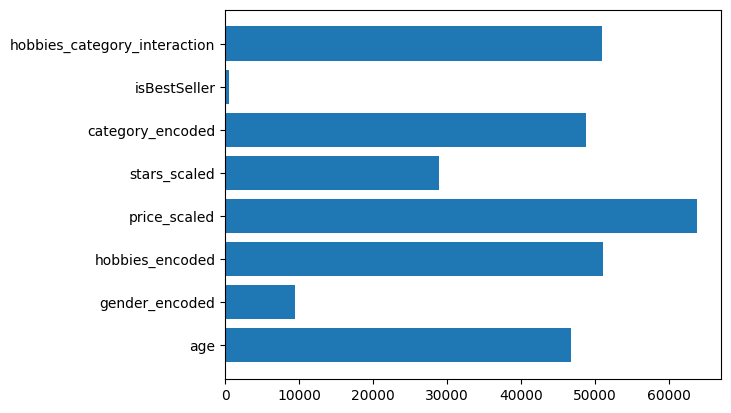

In [35]:
import matplotlib.pyplot as plt

feature_importances = final_model.feature_importances_
plt.barh(feature_cols, feature_importances)
plt.show()

In [36]:
print(df["category_encoded"].value_counts())


category_encoded
78     2016
34     1702
220    1508
240    1396
79     1337
       ... 
201       2
150       2
202       2
192       1
74        1
Name: count, Length: 248, dtype: int64


In [143]:
test = pd.read_csv("amazon_products_cleaned.csv")

print(test.head())

         asin                                              title  \
0  B014TMV5YE  Sion Softside Expandable Roller Luggage, Black...   
1  B07GDLCQXV  Luggage Sets Expandable PC+ABS Durable Suitcas...   
2  B07XSCCZYG  Platinum Elite Softside Expandable Checked Lug...   
3  B08MVFKGJM  Freeform Hardside Expandable with Double Spinn...   
4  B01DJLKZBA  Winfield 2 Hardside Expandable Luggage with Sp...   

                                              imgUrl  \
0  https://m.media-amazon.com/images/I/815dLQKYIY...   
1  https://m.media-amazon.com/images/I/81bQlm7vf6...   
2  https://m.media-amazon.com/images/I/71EA35zvJB...   
3  https://m.media-amazon.com/images/I/91k6NYLQyI...   
4  https://m.media-amazon.com/images/I/61NJoaZcP9...   

                             productURL  stars   price  category_id  \
0  https://www.amazon.com/dp/B014TMV5YE    4.5  139.99          104   
1  https://www.amazon.com/dp/B07GDLCQXV    4.5  169.99          104   
2  https://www.amazon.com/dp/B07XSCCZYG  

In [37]:
test_2 = pd.read_csv("final_dataset.csv")   
print(test_2.head())

   user_id  product_id  target  age  gender        hobbies  category_id  \
0     1825  B07FFCGVCS       0   40  female         sports           69   
1     4013  B09KX3GPZC       1   42    male           tech           97   
2     1680  B008E33K0W       1   39  female   fashion,cars          203   
3     6913  B0B4X11BHQ       1   62  female    gaming,cars          252   
4     3583  B00VMY21O6       0   20    male  sports,gaming          225   

   isBestSeller                        category_name  gender_encoded  \
0         False         Televisions & Video Products               0   
1         False                         Girls' Shoes               1   
2         False           Pumps & Plumbing Equipment               0   
3         False  Wii U Games, Consoles & Accessories               0   
4         False        Kids' Dress Up & Pretend Play               1   

   category_encoded  hobbies_encoded  hobbies_category_interaction  \
0               214              570          